# Examining Different Outflows
In this notebook, we will take a closer look at the different outflows identified within this project within the NGC 3324 region of the Carina Nebula.
The program `outflow_lookup.py` is intended to query an .xlsx file with the different identified sources (e.g. PJ001, PJ002 etc.), and produce a cropped image of the protostellar outflow. 

In [1]:
# use the entire screen width for the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
# make interactive plots
%matplotlib widget

In [42]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob # for filepath handling
import sys
#
import warnings
warnings.filterwarnings('ignore')
#
# Astropy:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import LinearStretch, LogStretch, ZScaleInterval, \
    MinMaxInterval, simple_norm
import reproject as rpj # needed for reproject module

sys.path.append('../code')
from reproject_combine import reproject, make_rgb
from continuum_sub import ContinuumSubtract
import outflow_lookup as ol

First we will get the coordinates of a desired outflow. In this notebook as an example, we will use PJ001. The largest outflow observed in the data.

In [4]:
path_to_file = '/mnt/c/Users/pjjan/OneDrive - Maynooth University/DIAS/outflow_sources_NGC3324.xlsx' # Set file path of the excel file

focus = 'PJ001' # set the source name
coords = ol.get_coordinates(path_to_file, focus)

We now have the coordinates of the outflow **PJ001**. We now want to select an image or a group of images to 'crop' so just the outflow is observed. For now, we will use all the NIRCam images.

In [7]:
# Get image file names
img_dir = '/mnt/d/st_images/Carina_level3/'
files = glob.glob(img_dir + '*nircam*')
print('Files found:')
for f in files:
    print(f)

Files found:
/mnt/d/st_images/Carina_level3/jw02731-o001_t017_nircam_clear-f090w_i2d.fits
/mnt/d/st_images/Carina_level3/jw02731-o001_t017_nircam_clear-f187n_i2d.fits
/mnt/d/st_images/Carina_level3/jw02731-o001_t017_nircam_clear-f200w_i2d.fits
/mnt/d/st_images/Carina_level3/jw02731-o001_t017_nircam_clear-f335m_i2d.fits
/mnt/d/st_images/Carina_level3/jw02731-o001_t017_nircam_clear-f444w_i2d.fits
/mnt/d/st_images/Carina_level3/jw02731-o001_t017_nircam_f444w-f470n_i2d.fits


We will use the ***F444W-F470N*** image as we did before for continuum subtraction as our target image. This image will be used to calculate its WCS information and for reprojection/resizing of other images onto it. 

In [10]:
target = files[5]
with fits.open(target) as hdu:
    tar_header = hdu['SCI'].header
    tar_data = hdu['SCI'].data

target_wcs = WCS(tar_header) # get target WCS info
pixel_x, pixel_y = target_wcs.world_to_pixel(coords) # get pixel coordinates of the outflow
pixel_x, pixel_y = int(pixel_x), int(pixel_y) # set them to integers for cropping

Now setting up the pixel region to focus on around the focus point.

In [12]:
y_pm = 300 # Setup y plus-minus
x_pm = 300 # Seyup x plus-minus
region = ol.pixel_region(pixel_x, pixel_y, x_pm, y_pm) # Define region

Reproject desired images onto the target world coordinate system (WCS) and then crop them to the region defined above.

In [13]:
reproj = reproject(files, target_wcs, tar_data) # Reprojection
cropped_imgs = ol.crop_images(reproj, region) # cropping

It is now desirable to make an RGB image of the 'PJ001' outflow. We will make use of `reproject_combine.py`'s `make_rgb` function to do so, passing the cropped images to it.

In [14]:
custom_stack = [0, 2, 3, 3, 4, 5] # setting up custom stacking order for make_rgb()
rgb = make_rgb(cropped_imgs, stretch=37, Q=0, minimum=0, custom_stack=custom_stack)

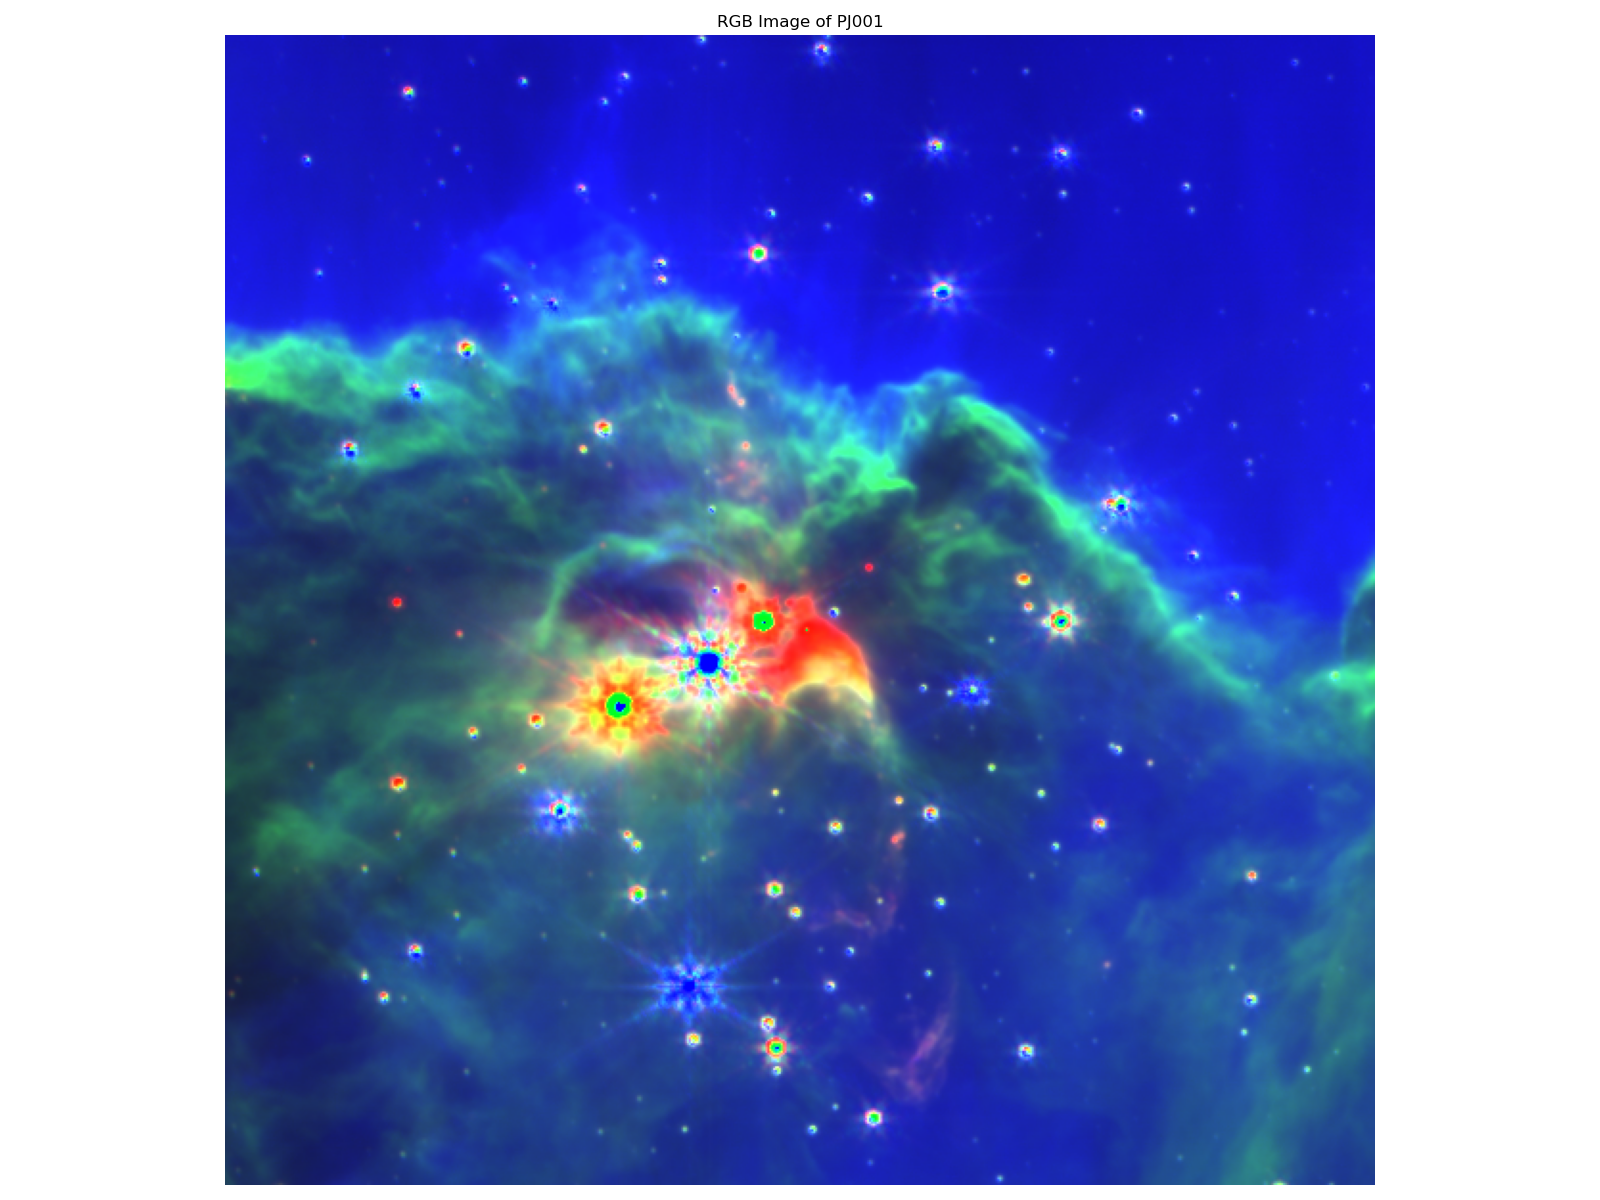

In [18]:
# Plotting rgb image
plt.figure(figsize=(16,12))
ax = plt.subplot(1, 1, 1)
im = ax.imshow(rgb, origin='lower')
ax.set_title(f'RGB Image of {focus}')
plt.axis('off')
plt.tight_layout()

Now let's do the same thing but for another outflow, this time looking at the prominent type 2 outflow **PJ006**

In [45]:
focus = 'PJ006'
coords = ol.get_coordinates(path_to_file, focus)
pixel_x, pixel_y = target_wcs.world_to_pixel(coords) # get pixel coordinates of the outflow
pixel_x, pixel_y = int(pixel_x), int(pixel_y) # set them to integers for cropping

y_pm = 250 # Setup y plus-minus
x_pm = 250 # Seyup x plus-minus
region = ol.pixel_region(pixel_x, pixel_y, x_pm, y_pm) # Define region

cropped_imgs = ol.crop_images(reproj, region) # cropping

In [46]:
custom_stack = [0, 2, 3, 3, 4, 5] # setting up custom stacking order for make_rgb()
rgb = make_rgb(cropped_imgs, stretch=30, Q=0, minimum=[0, 5, 5], custom_stack=custom_stack) # make rgb image

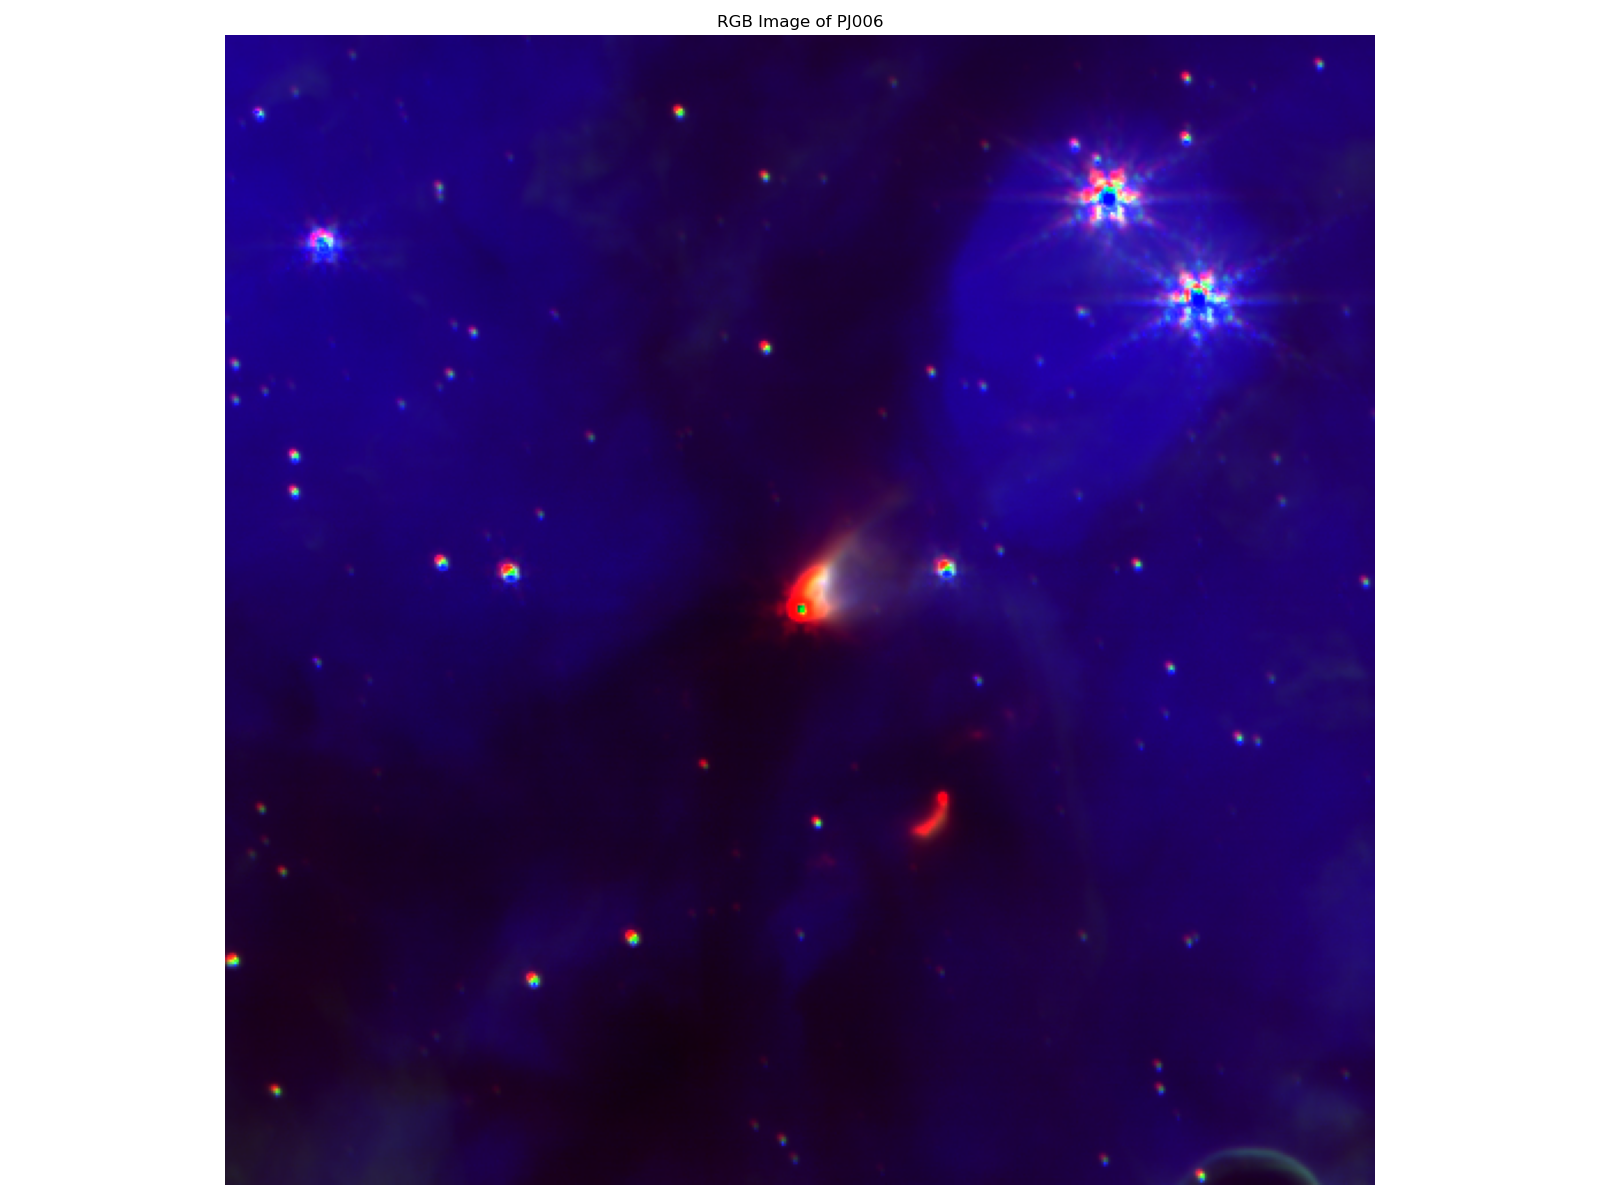

In [47]:
# Plotting rgb image
plt.figure(figsize=(16,12))
ax = plt.subplot(1, 1, 1)
im = ax.imshow(rgb, origin='lower')
ax.set_title(f'RGB Image of {focus}')
plt.axis('off')
plt.tight_layout()

Let's take another look at PJ006 but without the continuum. Using the `ContinuumSubtract` class from `continuum_sub.py`, we will produce the same image above but isolating the outflow itself.

In [48]:
c = ContinuumSubtract(files[5], files[4])
reproj_c = [cropped_imgs[4], cropped_imgs[5]]
scale_factor = 0.9756262810503796 # obtained in Continuum_subtract notebook
subc = c.continuum_sub(reproj_c, scale_factor)

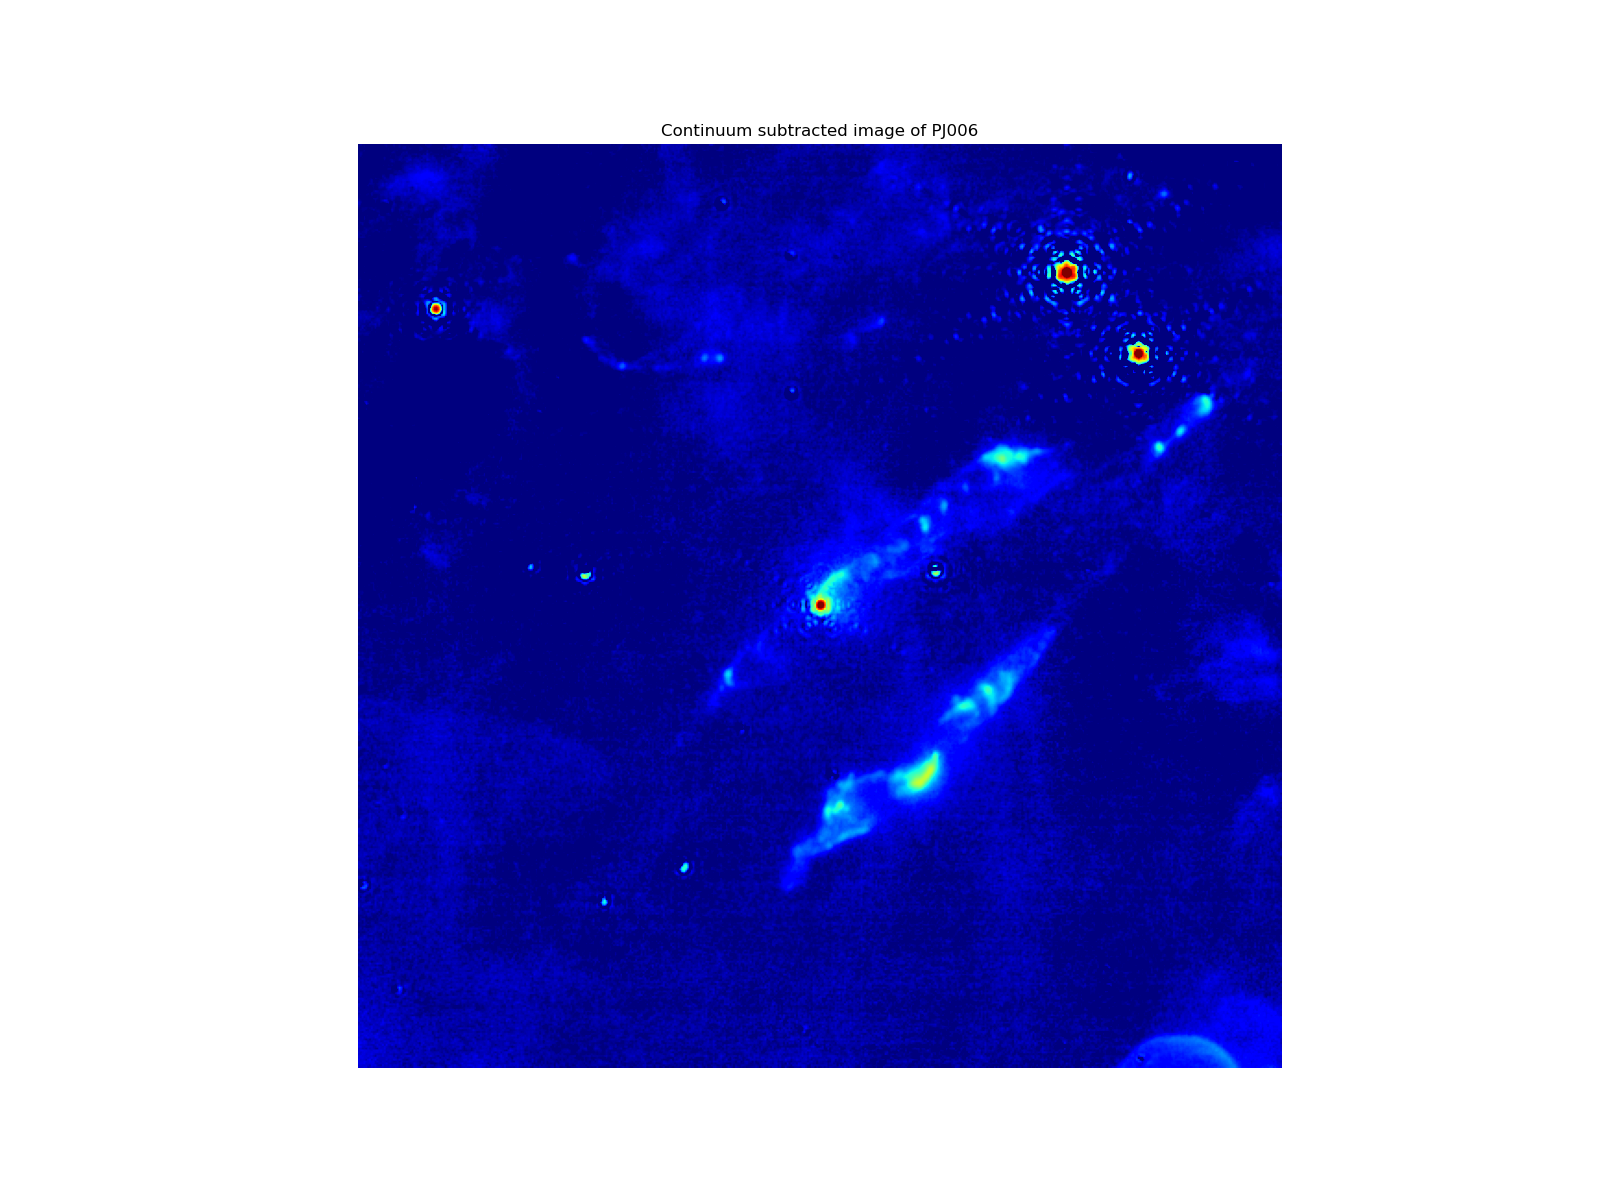

In [49]:
# Plot PJ006
fig = plt.figure(figsize=(16,12))
ax1 = plt.subplot(1, 1, 1)
im = ax1.imshow(subc, origin='lower', norm = simple_norm(subc, stretch='log', invalid=0, min_cut=0, max_cut=900), cmap='jet')
ax1.set_title(f'Continuum subtracted image of {focus}')
plt.axis('off')
plt.show()
plt.tight_layout()